In [ ]:
!pip3 install numpy==1.22.1 matplotlib==3.8 opencv-python gtsam tqdm open3d

In [ ]:
!pip install typeguard

In [67]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gtsam
import glob
import open3d as o3d
from tqdm import tqdm

In [68]:
# # KITTI
# fx, fy = 718.856, 718.856
# cx, cy = 607.1928, 185.2157

# TUM
fx, fy, cx, cy = 0.535719308086809 * 1280,	0.669566858850269 * 1024,	0.493248545285398 * 1280,	0.500408664348414 * 1024
omega = 0.897966326944875

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)


K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)

In [69]:
# --- Parameters ---
# images_path = "../dataset/images/04/image_0/*.png"
# images_path = "../dataset/images/17/*.png"
images_path = "../dataset/images/TUM/sequence_49/images_downsampled/*.jpg"
min_features = 2000
FIRST_FRAME = 180
N_FRAMES = 100

# --- Load and sort images ---
image_files = sorted(glob.glob(images_path))[FIRST_FRAME:FIRST_FRAME+N_FRAMES]
if not image_files:
    raise RuntimeError("No images found in folder!")
print(f"Images loaded: {len(image_files)}")

# --- Initialize FAST detector ---
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

Images loaded: 100


In [70]:
import numpy as np

def undistort_points_fov(points_2d, K, omega):
    """
    Undistorts 2D keypoints using the FOV (Field of View) distortion model.
    Handles inputs of shape (N, 2) or (N, 1, 2).
    
    Args:
        points_2d: Numpy array of shape (N, 2) or (N, 1, 2).
        K: Intrinsic matrix (3x3).
        omega: The distortion parameter (scalar).
        
    Returns:
        Undistorted points matching the input shape.
    """
    if len(points_2d) == 0:
        return points_2d

    # 1. Handle Shape (N, 1, 2) -> (N, 2)
    original_shape = points_2d.shape
    points_2d = points_2d.reshape(-1, 2) # Flatten to (N, 2) for math

    # 2. Convert to Normalized Coordinates (remove K)
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x_dist = (points_2d[:, 0] - cx) / fx
    y_dist = (points_2d[:, 1] - cy) / fy
    
    # 3. Calculate distorted radius
    r_dist = np.sqrt(x_dist**2 + y_dist**2)
    
    # 4. Apply Inverse FOV Model
    if abs(omega) < 1e-5:
        r_undist = r_dist
    else:
        # Formula: r_u = tan(r_d * omega) / (2 * tan(omega / 2))
        r_undist = np.tan(r_dist * omega) / (2 * np.tan(omega / 2.0))
    
    # 5. Scale the coordinates
    with np.errstate(divide='ignore', invalid='ignore'):
        scale = r_undist / r_dist
        scale[r_dist < 1e-7] = 1.0
    
    x_undist = x_dist * scale
    y_undist = y_dist * scale
    
    # 6. Convert back to Pixel Coordinates (apply K)
    x_final = x_undist * fx + cx
    y_final = y_undist * fy + cy
    
    # Stack and Reshape back to original input shape (N, 1, 2) or (N, 2)
    undistorted = np.stack((x_final, y_final), axis=1)
    return undistorted.reshape(original_shape)

In [ ]:
# --- Helper: detect new features and assign IDs ---
def detect_new_features(img, existing_ids):
    global next_feature_id
    keypoints = fast.detect(img, None)
    new_pts = []
    new_ids = []
    for kp in keypoints:
        x, y = kp.pt
        new_pts.append([x, y])
        new_ids.append(next_feature_id)
        next_feature_id += 1
    points = np.array(new_pts, dtype=np.float32).reshape(-1, 1, 2)
    undistorted_points = undistort_points_fov(points_2d=points, K=K, omega=omega)
    return undistorted_points, new_ids

In [72]:
# --- Tracking state ---
next_feature_id = 0  # unique ID counter
tracked_points = {}  # {id: (x,y)}
tracks_per_frame = []  # list of dicts: [{id: (x,y)}, ...]

# --- First frame ---
prev_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
prev_pts, prev_ids = detect_new_features(prev_img, set())

tracks_per_frame.append({pid: tuple(pt.ravel()) for pid, pt in zip(prev_ids, prev_pts)}) # first image

# --- Process frames ---
for fname in tqdm(image_files[1:N_FRAMES]): # iterate over all remaining frames
    frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Track previous points with optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, frame, prev_pts, None)
    status = status.flatten()

    # Keep only successfully tracked points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]
    good_ids = [pid for pid, st in zip(prev_ids, status) if st == 1]

    # Update positions
    for pid, pt in zip(good_ids, good_new):
        tracked_points[pid] = pt

    # If features drop below threshold, add new ones
    if  len(good_new) < min_features:
        new_pts, new_ids = detect_new_features(frame, set(good_ids))
        good_new = np.vstack([good_new.reshape(-1, 1, 2), new_pts])
        good_ids.extend(new_ids)
    

    # Store current frame's tracks
    tracks_per_frame.append({pid: pt.ravel() for pid, pt in zip(good_ids, good_new)})

    # Update for next frame
    prev_img = frame
    prev_pts = good_new.reshape(-1, 1, 2)
    prev_ids = good_ids


100%|██████████| 99/99 [00:01<00:00, 85.83it/s]


In [73]:
def compute_essential(tracks_per_frame, i, j, K):
    # Get correspondences by ID
    ids_i = set(tracks_per_frame[i].keys())
    ids_j = set(tracks_per_frame[j].keys())
    common_ids = list(ids_i & ids_j)  # intersection

    if len(common_ids) < 5:
        raise ValueError("Not enough matches to compute Essential matrix")

    pts1 = np.array([tracks_per_frame[i][pid] for pid in common_ids], dtype=np.float32)
    pts2 = np.array([tracks_per_frame[j][pid] for pid in common_ids], dtype=np.float32)

    # Compute essential matrix
    E, inliers = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    return E, inliers, pts1, pts2, np.array(common_ids)

In [74]:
def get_3D_points(tracks_per_frame, prev_frame_id, curr_frame_id, K, prev_R, prev_t, curr_R, curr_t, existing_ids):

    pts_prev = tracks_per_frame[prev_frame_id]
    pts_curr = tracks_per_frame[curr_frame_id]
    common_ids = list(pts_prev.keys() & pts_curr.keys()) # discard points that are not common to both frames

    existing_set = set(existing_ids)
    common_ids = [i for i in common_ids if i not in existing_set] # only want to triangulate points that are not in our 3D map already

    if len(common_ids) == 0: # we have nothing to work on
        return None, None, np.array([]), np.array([])

    pts1 = np.array([pts_prev[i] for i in common_ids], dtype=np.float64)
    pts2 = np.array([pts_curr[i] for i in common_ids], dtype=np.float64)

    _, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    if mask is None:
        return None, None, np.array([]), np.array([])
    
    mask = mask.ravel().astype(bool)
    pts1_inl = pts1[mask]
    pts2_inl = pts2[mask]
    ids_inl = np.array(common_ids)[mask]

    P1 = K @ np.hstack([prev_R, prev_t.reshape(3,1)]) 
    P2 = K @ np.hstack([curr_R, curr_t.reshape(3,1)])
    
    points_homogeneous = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)
    points_3d = (points_homogeneous[:3] / points_homogeneous[3]).T

    
    # transform points back from World Frame to Camera Frame in order to fiter out points that are too far away to be meaningful
    
    points_cam = (curr_R @ points_3d.T + curr_t.reshape(3,1)).T
    
    depths = points_cam[:, 2]

    MIN_DEPTH = 1.0 
    MAX_DEPTH = 40.0

    valid_mask = (depths > MIN_DEPTH) & (depths < MAX_DEPTH)
    
    points_3d = points_3d[valid_mask]
    ids_inl = ids_inl[valid_mask]
    
    return None, None, ids_inl, points_3d

In [75]:
# We compute the essential matrix for the first two frames
E, inliers, pts1, pts2, common_ids = compute_essential(tracks_per_frame, 0, 1, K)
print(f"Common points used: {len(common_ids)}")
print(f"E:\n{E}")

pts1 = np.asarray(pts1, dtype=np.float64).reshape(-1, 2)
pts2 = np.asarray(pts2, dtype=np.float64).reshape(-1, 2)
num_inliers, R1, t1, mask = cv2.recoverPose(E, pts1, pts2, K)

print(f"c1_R_w:\n{R1}")
print(f"c1_t_w:\n{t1}")

Common points used: 874
E:
[[ 0.04069557 -0.51163844 -0.14688787]
 [ 0.55137055  0.03029948  0.42513473]
 [ 0.16314775 -0.44901592 -0.03308126]]
c1_R_w:
[[ 0.99255891  0.09921446 -0.07059251]
 [-0.09558093  0.99400335  0.05311899]
 [ 0.07543936 -0.04597643  0.99608989]]
c1_t_w:
[[ 0.65573461]
 [ 0.16930988]
 [-0.73576239]]


In [76]:
# Projection matrices
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))]) # R0 ant t0 are respectively [I], [0,0,0]
P2 = K @ np.hstack([R1, t1])

# Select only inlier correspondences
inlier_mask = mask.ravel().astype(bool)
pts1_inl = pts1[inlier_mask]
pts2_inl = pts2[inlier_mask]
common_ids_inl = common_ids[inlier_mask]
print(f"Inliers: {len(common_ids_inl)}")

# Triangulate
points_h = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)

# Convert from homogeneous to 3D
points_3d_ids = common_ids_inl
points_3d = (points_h[:3] / points_h[3]).T # normalize bc they are homogeneous coordinates

Inliers: 859


In [77]:
'''
PnP is the problem of estimating the pose of a calibrated camera given a set of n 3D points in the world
and their corresponding 2D projections in the image
'''

def register_frame_pnp(tracks_per_frame, frame_idx, points_3d, point_ids, K):
    # Build 3D-2D correspondences
    pts3d = []
    pts2d = []
    for pid, X in zip(point_ids, points_3d):
        if pid in tracks_per_frame[frame_idx]:
            pts3d.append(X)
            pts2d.append(tracks_per_frame[frame_idx][pid])
    if len(pts3d) < 6:
        raise ValueError(f"Frame {frame_idx}: not enough 2D-3D matches for PnP")

    pts3d = np.array(pts3d, dtype=np.float64)
    pts2d = np.array(pts2d, dtype=np.float64)

    # Solve PnP with RANSAC
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, distCoeffs=None,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if not success:
        raise RuntimeError(f"PnP failed for frame {frame_idx}")

    # Convert to rotation matrix
    R, _ = cv2.Rodrigues(rvec)
    t = tvec.ravel()

    return R, t, inliers

In [78]:
initial_poses = [(np.identity(3), np.zeros((3, 1))), (R1, t1)]
MIN_INLIERS = 200

prev_R = R1
prev_t = t1

for idx in tqdm(range(2, N_FRAMES)):
    
    R, t, inliers = register_frame_pnp(
        tracks_per_frame, idx, points_3d, points_3d_ids, K
    )

    # resampling
    if len(inliers) < MIN_INLIERS:
        _, _, new_ids, new_pts = get_3D_points(
            tracks_per_frame=tracks_per_frame, 
            prev_frame_id=idx-1, 
            curr_frame_id=idx, 
            K=K, 
            prev_R=prev_R, 
            prev_t=prev_t, 
            curr_R=R,
            curr_t=t,
            existing_ids=points_3d_ids
        )
        
        if len(new_pts) > 0:
            points_3d = np.vstack((points_3d, new_pts))
            points_3d_ids = np.concatenate((points_3d_ids, new_ids))
            print(f"Added {len(new_pts)} new points. New size: {len(points_3d)}")

    prev_R = R
    prev_t = t
    initial_poses.append((R, t))
    
    print(f"Registered frame {idx} inliers {len(inliers)}")

 10%|█         | 10/98 [00:00<00:00, 99.72it/s]

Registered frame 2 inliers 640
Registered frame 3 inliers 487
Registered frame 4 inliers 324
Registered frame 5 inliers 238
Added 771 new points. New size: 1630
Registered frame 6 inliers 128
Registered frame 7 inliers 587
Registered frame 8 inliers 389
Registered frame 9 inliers 356
Registered frame 10 inliers 395
Registered frame 11 inliers 358
Registered frame 12 inliers 290
Registered frame 13 inliers 338
Registered frame 14 inliers 324
Registered frame 15 inliers 332
Registered frame 16 inliers 308
Registered frame 17 inliers 296
Registered frame 18 inliers 286
Registered frame 19 inliers 251
Registered frame 20 inliers 251
Registered frame 21 inliers 234
Added 1328 new points. New size: 2958
Registered frame 22 inliers 177
Registered frame 23 inliers 892


 26%|██▌       | 25/98 [00:00<00:00, 128.48it/s]

Registered frame 24 inliers 693
Registered frame 25 inliers 723
Registered frame 26 inliers 734


 41%|████      | 40/98 [00:00<00:00, 134.76it/s]

Registered frame 27 inliers 687
Registered frame 28 inliers 648
Registered frame 29 inliers 626
Registered frame 30 inliers 589
Registered frame 31 inliers 442
Registered frame 32 inliers 530
Registered frame 33 inliers 532
Registered frame 34 inliers 442
Registered frame 35 inliers 453
Registered frame 36 inliers 425
Registered frame 37 inliers 523
Registered frame 38 inliers 477
Registered frame 39 inliers 514
Registered frame 40 inliers 523
Registered frame 41 inliers 486
Registered frame 42 inliers 482
Registered frame 43 inliers 480
Registered frame 44 inliers 491
Registered frame 45 inliers 480
Registered frame 46 inliers 463
Registered frame 47 inliers 485
Registered frame 48 inliers 451
Registered frame 49 inliers 395
Registered frame 50 inliers 390
Registered frame 51 inliers 332
Registered frame 52 inliers 400
Registered frame 53 inliers 415


 57%|█████▋    | 56/98 [00:00<00:00, 143.16it/s]

Registered frame 54 inliers 270
Registered frame 55 inliers 339
Registered frame 56 inliers 373
Registered frame 57 inliers 387


 72%|███████▏  | 71/98 [00:00<00:00, 132.76it/s]

Registered frame 58 inliers 286
Added 992 new points. New size: 3950
Registered frame 59 inliers 124
Registered frame 60 inliers 965
Registered frame 61 inliers 870
Registered frame 62 inliers 860
Registered frame 63 inliers 836
Registered frame 64 inliers 608
Registered frame 65 inliers 813
Registered frame 66 inliers 807
Registered frame 67 inliers 800
Registered frame 68 inliers 767
Registered frame 69 inliers 774
Registered frame 70 inliers 638
Registered frame 71 inliers 597
Registered frame 72 inliers 361
Registered frame 73 inliers 524
Registered frame 74 inliers 309
Registered frame 75 inliers 265
Registered frame 76 inliers 325
Registered frame 77 inliers 337
Registered frame 78 inliers 366
Registered frame 79 inliers 231
Registered frame 80 inliers 213
Added 909 new points. New size: 4859
Registered frame 81 inliers 189
Registered frame 82 inliers 858


 87%|████████▋ | 85/98 [00:00<00:00, 128.16it/s]

Registered frame 83 inliers 915
Registered frame 84 inliers 827
Registered frame 85 inliers 793
Registered frame 86 inliers 664
Registered frame 87 inliers 762
Registered frame 88 inliers 618
Registered frame 89 inliers 490
Registered frame 90 inliers 458
Registered frame 91 inliers 380
Added 157 new points. New size: 5016
Registered frame 92 inliers 130
Registered frame 93 inliers 332
Registered frame 94 inliers 229
Added 60 new points. New size: 5076
Registered frame 95 inliers 140
Registered frame 96 inliers 218
Registered frame 97 inliers 201
Registered frame 98 inliers 266


100%|██████████| 98/98 [00:00<00:00, 100.91it/s]

Added 24 new points. New size: 5100
Registered frame 99 inliers 154


In [79]:
graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()
cal = gtsam.Cal3_S2(fx, fy, 0, cx, cy)

# Build robust noise model: Robust(Cauchy, Isotropic(sigma)) ---
base_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1)
cauchy_mest = gtsam.noiseModel.mEstimator.Cauchy(3)
robust_noise = gtsam.noiseModel.Robust(cauchy_mest, base_noise)

# Insert poses
camera_ids = []
for idx, pose in enumerate(initial_poses):
  cam_sym = gtsam.symbol('c', idx)
  cam_pose = gtsam.Pose3(gtsam.Rot3(pose[0]), pose[1]).inverse()
  initial_values.insert(cam_sym, cam_pose)
  camera_ids.append(cam_sym)

# Add a prior on the first pose to fix scale/pose gauge ---
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6]*6))  # strong prior
cam_sym = gtsam.symbol('c', 0)
graph.add(gtsam.PriorFactorPose3(cam_sym, gtsam.Pose3(), pose_prior_noise))

points_ids = []
for point_idx, point in zip(points_3d_ids, points_3d):
  # Check if 3d points is seen in at least 3 images if not skip the point
  observations = [(img_idx, pts[point_idx]) for img_idx, pts in enumerate(tracks_per_frame) if point_idx in pts]
  if len(observations) < 3:
    continue

  # Add point symbol
  point_sym = gtsam.symbol('p', point_idx)
  initial_values.insert(point_sym, point)
  points_ids.append(point_sym)

  # Add reprojection factors
  for img_idx, point_2d in observations:
    measured = gtsam.Point2(point_2d[0], point_2d[1])
    cam_sym = gtsam.symbol('c', img_idx)
    proj_factor = gtsam.GenericProjectionFactorCal3_S2(measured, robust_noise, cam_sym, point_sym, cal)
    graph.add(proj_factor)

print(f"Total points inserted {len(points_ids)}")

Total points inserted 5088


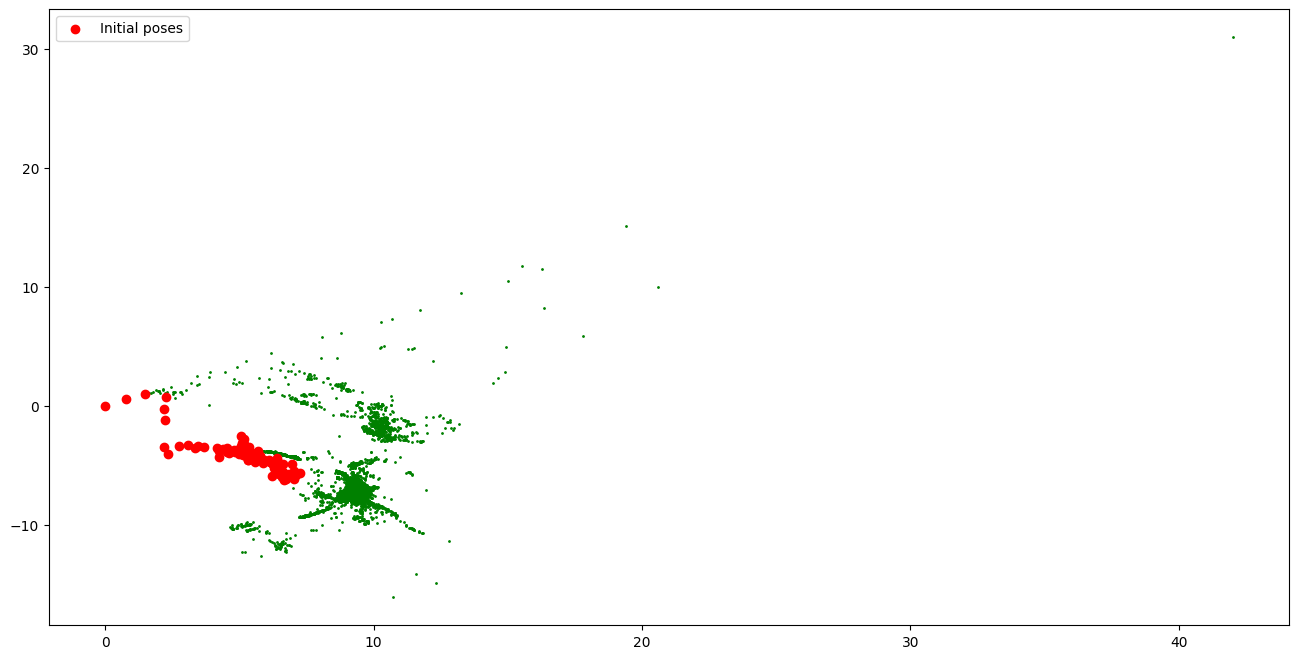

In [80]:
initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # OSS: z, -x in camera coordinates becomes x,y in world coordinates if the orientation of the camera is z = forward, x = right, y = downwards
initial_poses = np.array(initial_poses)

points = []
for point_sym in points_ids:
    point = initial_values.atPoint3(point_sym)
    points.append((point[2], -point[0]))
points = np.array(points)

# here we are plotting the original camera poses (pose_initial) and 3D points (point) before we optimize
plt.figure(figsize=(16,8))
plt.scatter(points[:, 0], points[:, 1], c='green', s=1)
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.legend()

In [81]:
# Optimize
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setVerbosityLM("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params) # see theory
result = optimizer.optimize()
optimizer.print()

converged
errorThreshold: 2410527.3858 <? 0
absoluteDecrease: 23.7952788314 <? 1e-05
relativeDecrease: 9.87130205664e-06 <? 1e-05
iterations: 80 >? 100
LevenbergMarquardtOptimizer
  parameters:

relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: TERMINATION
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: TERMINATION


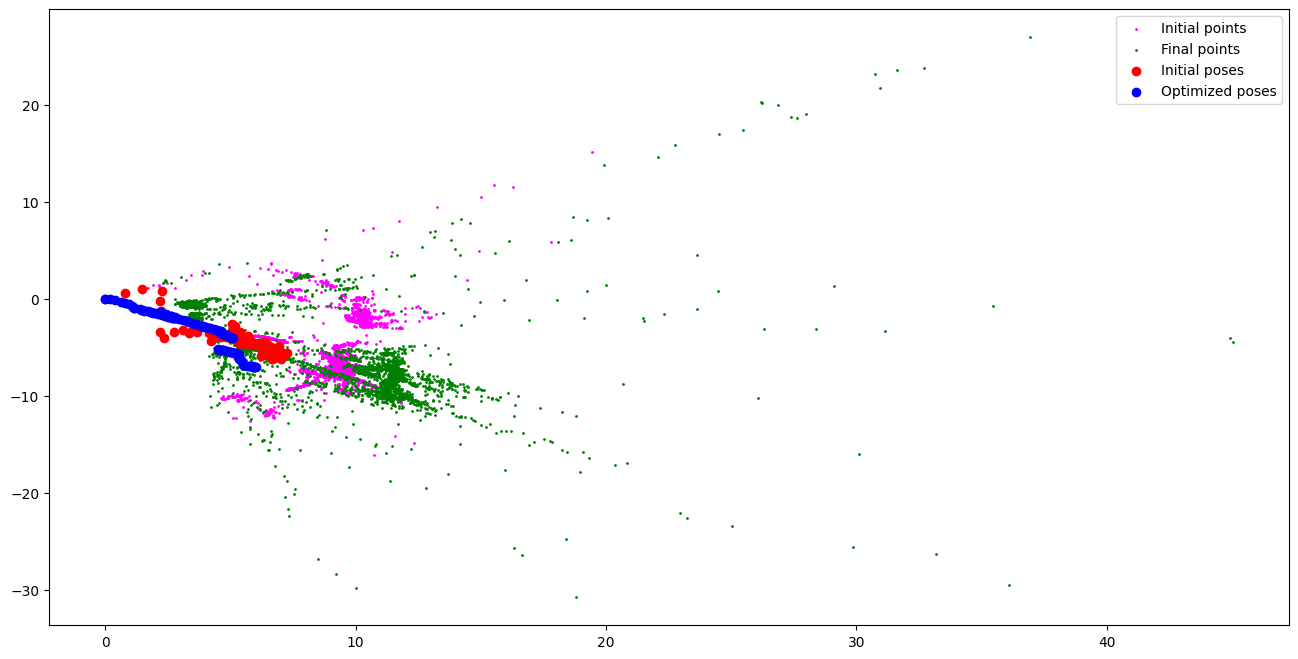

In [82]:
# Keep same scale factor of initial poses
scale = np.linalg.norm(initial_values.atPose3(camera_ids[-1]).translation()) / np.linalg.norm(result.atPose3(camera_ids[-1]).translation())
# explanation: the norm of the position of the last camera is the overall distance covered in a straight line, 
# we can compute the common scale scale factor as the ratio between the distance covered in the first experiement and the 
# distance covered in the result after optimization 

initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # same reason as before

  pose_final = result.atPose3(cam_sym)
  final_poses.append((scale*pose_final.translation()[2], -scale*pose_final.translation()[0]))

initial_poses = np.array(initial_poses)
final_poses = np.array(final_poses)


initial_points = []
points = []
for point_sym in points_ids:
    point_initial = initial_values.atPoint3(point_sym)
    point_final = result.atPoint3(point_sym)
    if np.linalg.norm(point_final) > 50/scale or point_final[2] < 0:
      continue
    initial_points.append((point_initial[2], -point_initial[0]))
    points.append((scale*point_final[2], -scale*point_final[0]))
initial_points = np.array(initial_points)
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='magenta', s=1, label='Initial points')
plt.scatter(points[:, 0], points[:, 1], c='green', s=1, label='Final points')
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.scatter(final_poses[:, 0], final_poses[:, 1], c='blue', label='Optimized poses')
plt.legend()


In [83]:
# ts does not work
# def gtsam_result_to_open3d(result, pose_keys_prefix='c', point_keys_prefix='p'):
#     geometries = []

#     # --- Collect 3D points ---
#     pts = []
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == point_keys_prefix:
#             pt = result.atPoint3(key)
#             if np.linalg.norm(pt) > 100/scale or pt[2] < 0:
#                 continue
#             pts.append([pt[0]*scale, pt[1]*scale, pt[2]*scale])
#     if pts:
#         pts_np = np.array(pts)
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(pts_np)
#         pcd.paint_uniform_color([0.1, 0.7, 0.1])  # green points
#         geometries.append(pcd)

#     # --- Collect camera poses as coordinate frames ---
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == pose_keys_prefix:
#             pose = result.atPose3(key)
#             T = pose.matrix()
#             T[0:3, 3] *= scale
#             frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
#             frame.transform(T)   # apply pose transform
#             geometries.append(frame)

#     return geometries
# geometries = gtsam_result_to_open3d(result)
# o3d.visualization.draw_geometries(geometries, )
